# Machine Learning Project

In [ ]:
# João Bernardo Baptista Vieira Dias - 293133
# Franciska-Leonóra Török - 293171

The assignments below should be solved and documented as a project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises.
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to.

Please hand in assignment 1-6 in a _**single**_ Jupyter notebook where you retain the questions outlined below. You are welcome to adapt code from the web (e.g. Kaggle kernels), but you **_must_** reference the original source in your notebook. In addition to _clean, well-documented code_ (i.e. functions with <a href="https://www.geeksforgeeks.org/python-docstrings/">docstrings</a>, etc), your notebook will be judged according to how well each step is explained (using Markdown). 

In general, direct questions regarding assignments 1, 4, 5 and 6 to Frederik, and questions regarding assignments 2, 3, and 7 to Richard. 

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

**Groups:** Create your own groups. May be across teams. 2-4 students per group. No one-person groups.


**Submission deadline:** Thursday, December 15 before 13.00 CET (Notebooks + presentation recording)

**Expected workload:** Each student is expected to spend around around 50 hours on the project.

### Deliverables
The teams have to submit three deliverables before the submission deadline: 1) a notebook of assignments 1-6, 2) a notebook of assignment 7, and 3) presentation video uploaded to some online platform e.g. YouTube, Vimeo, etc.

#### Notebook
The notebook contains all the code to explore the dataset, train the final model and documents each step clearly. If code is copied from another codebase such as Github or Stack Overflow it **_must_** be properly referenced.


#### Presentation
The presentation video should be 15 min long and should highlight the problem you are solving, interesting things you found in the data and the step involved in building up your model. At the exam we will discuss the presentation and ask questions about your project and submissions. A link to the video must be placed in the notebook for assignment 7.

### Randomness
For ALL random states, choose state = 69 so we can replicate your work.


In [181]:
# Import all necessary modules here:
import pandas as pd
import csv
import re
import os
import ast
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.utils import resample
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, classification_report
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from scipy.cluster.hierarchy import dendrogram

## 1. The IceCat Dataset (Franciska)

__You should be able to do this exercise after Lecture 3.__

The IceCat Dataset, kindly provided to us by Stibo Systems, contains a large amount of data on different office products. As an example of "real-world" data, these data are imperfect and incomplete. As such, this exercise is not so much an exercise in creating a good machine learning model, but places a larger emphasis on "cleaning the data".

We are going to work with a subset of the IceCat Dataset. In particular, you will be provided with a zip file of 5,854 images of office products, each with the name "product ID".jpg. You will also be provided with a list of colors, `colors.txt`, which, when imported using the code below, is a list of tuples of the form `[("product ID", "color"), ...]`. (The code below assumes that `colors.txt` is in the same folder as the jupyter notebook. Feel free to change the code if you prefer a different organization of your files).

In [182]:
# Cleaning up the data

colors = []

# Read the data from the colors.txt file
with open('1 The IceCat Dataset/colors.txt') as f:
    for line in f:
        # Use regular expressions to extract the product ID and color labels
        # from each line in the file
        matches = re.findall(r'\((\d+),([^)]+)\)', line)
        for match in matches:
            product_id = int(match[0])
            color_labels = match[1].strip().split(',')
            colors.append((product_id, color_labels))

In [183]:
def select_features(X, y):
    select = SelectPercentile(percentile=75) 
    result = select.fit_transform(X, y)
    return result

In [184]:
def load_color_labels():
    with open("1 The IceCat Dataset/colors.txt","r") as file:
        colors = ast.literal_eval(file.read())
        result = pd.DataFrame(colors, columns = ['product_id', 'color'])
        return result

In [185]:
color_labels = load_color_labels()
image_list = os.listdir("1 The IceCat Dataset/images")

print(color_labels, len(image_list))

      product_id                  color
0           1710            Blue, White
1           1983                  Cream
2          19832                   Grey
3          23112                  Black
4          23621  Metallic, Transparent
...          ...                    ...
5849    89527433                  Black
5850    90111420                  Black
5851    91233324                  Black
5852    91689185                  White
5853    91689194                  White

[5854 rows x 2 columns] 5854


In [203]:
def remove_multi_labels(images, colors):
    result_colors = colors[colors.apply(lambda row: len(row['color'].split(',')) == 1, axis=1)]
    result_images = images.copy()
    
    for image in images:
        if image.split('.')[0] not in str(result_colors.product_id.values.tolist()):
            result_images.remove(image)
    return (result_images, result_colors)

In [205]:
image_list, color_labels = remove_multi_labels(image_list, color_labels)
print(color_labels.shape, len(image_list))
print(color_labels)

(4521, 2) 4521
      product_id  color
1           1983  Cream
2          19832   Grey
3          23112  Black
5          24177   Grey
6          24546  Black
...          ...    ...
5849    89527433  Black
5850    90111420  Black
5851    91233324  Black
5852    91689185  White
5853    91689194  White

[4521 rows x 2 columns]


In [206]:
# Remove Multicolour rows

def remove_multicolour(images, colors):
    result_colors = colors.drop(colors[colors.color == "Multicolour"].index)
    result_images = images.copy()
    
    for image in images:
        if image.split('.')[0] not in str(result_colors.product_id.values.tolist()):
            result_images.remove(image)
    return (result_images, result_colors)

In [207]:
single_color_image_list, single_color_labels = remove_multicolour(image_list, color_labels)
print(len(single_color_image_list), len(single_color_labels))

4287 4287


In [208]:
# The occurences each unique color has
single_color_labels['color'].value_counts()

Black               1034
White                694
Blue                 470
Grey                 392
Transparent          344
Red                  276
Green                217
Yellow               203
Silver               139
Brown                 95
Orange                89
Wood                  71
Pink                  50
Purple                38
Violet                22
Aluminium             21
Gold                  15
Turquoise             15
Stainless steel       14
Assorted colours      13
Metallic              13
Beige                 13
Anthracite             6
Platinum               5
Cyan                   4
Bronze                 3
Rose                   3
Magenta                3
Chrome                 3
Bordeaux               3
Light grey             3
Multi                  2
Navy                   2
Cream                  2
Translucent            2
Ivory                  2
Lime                   1
Sand                   1
Olive                  1
Charcoal               1


In [209]:
# This code uses a dictionary to map color groups to their corresponding colors.
# Then iterates through the color column of a dataframe to classify each color into a group. 
# If a color matches a color in a group, it appends the name of that group to a list. 
# If no match is found, it appends the original color to the list. 
# Finally, it creates a copy of the original dataframe and replaces the color column with the classified colors.

def group_similar_labels(labels):
    color_groups = {
        'Multicolour': ['Assorted colours', 'Multi'],
        'Silver': ['Metallic', 'Stainless steel', 'Aluminium', 'Platinum', 'Titanium', 'Chrome'],
        'Purple': ['Violet'],
        'Brown': ['Cappuccino', 'Wood', 'Oak colour', 'Beige'],
        'Grey': ['Charcoal', 'Graphite', 'Light grey'],
        'Black': ['Anthracite'],
        'White': ['Ivory', 'Cream'],
        'Pink': ['Magenta', 'Rose'],
        'Red': ['Bordeaux'],
        'Blue': ['Navy'],
        'Transparent': ['Translucent']
    }
    
    result = labels.copy()
    for group_name, group_colors in color_groups.items():
        result.loc[result['color'].isin(group_colors), 'color'] = group_name
    
    return result

Number of times each color occurs: 
Black               1034
White                694
Blue                 470
Grey                 392
Transparent          344
Red                  276
Green                217
Yellow               203
Silver               139
Brown                 95
Orange                89
Wood                  71
Pink                  50
Purple                38
Violet                22
Aluminium             21
Gold                  15
Turquoise             15
Stainless steel       14
Assorted colours      13
Metallic              13
Beige                 13
Anthracite             6
Platinum               5
Cyan                   4
Bronze                 3
Rose                   3
Magenta                3
Chrome                 3
Bordeaux               3
Light grey             3
Multi                  2
Navy                   2
Cream                  2
Translucent            2
Ivory                  2
Lime                   1
Sand                   1
Olive         

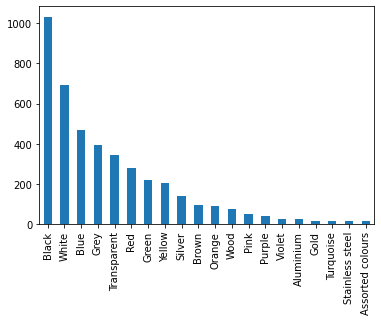

In [210]:
# Count the number of times each color occurs in the dataframe
color_counts = single_color_labels['color'].value_counts()
print(f'Number of times each color occurs: \n{color_counts}')

# Since there are many colors, let's select only the top-occurring color labels from the dataframe
top_colors = single_color_labels.loc[single_color_labels['color'].isin(color_counts.index[:20])]

# Create a bar chart to visualize the color counts
top_colors['color'].value_counts().plot(kind='bar')

# Show the chart
plt.show()

In [211]:
# Test grouping colors

# Define test data
# test_data = ['Assorted colours', 'Platinum', 'Oak colour', 'Navy']
test_data = pd.DataFrame(data=test_data, columns=['color'])

# Group the test data
rs = group_similar_labels(test_data)

# Print the result
print(rs)

         color
0  Multicolour
1       Silver
2        Brown
3         Blue


In [212]:
# Convert the list to a DataFrame
colors = color_labels.copy()

def remove_categories_with_small_sample_size(colors, images_dir_list):
    # Remove categories with small sample size
    colors_to_remove = colors[colors.groupby('color').color.transform('count')<=30].product_id.values
    result_images = images_dir_list.copy()
    
    for image in images_dir_list:
        if image.split('.')[0] in str(colors_to_remove):
            result_images.remove(image)
    
    result_colors = colors[colors.groupby('color').color.transform('count')>17]
    return (result_images, result_colors)

In [213]:
# Create a list of images by removing multicolours
single_color_image_list, single_color_labels = remove_multicolour(image_list, color_labels)

# Group the data by single color labels
grouped_labels = group_similar_labels(single_color_labels)

# Remove categories with small sample size
img, clrs = remove_categories_with_small_sample_size(grouped_labels, single_color_image_list)

# Print the shape and length of the updated image list and labels
print(clrs.shape, len(img))

(4232, 2) 4232


In [214]:
# Load images

def load_images_to_X(images):
    result = []
    
    for i in range(len(images)):
        try:
            img = Image.open("1 The IceCat Dataset/images/"+images[i]).convert("RGB")
            img_resize = img.resize((100,100))
            row = np.asarray(img_resize).ravel()
            result.append(row)
            print("Image file " + images[i] + " succesfully read")
        except:
            # Handle error
            print("Error: could not open or read image file " + images[i])
    return result

In [215]:
def scale_features(images):
    scaler = StandardScaler()
    return scaler.fit_transform(images)

In [216]:
def remove_rejected_samples(images, colors):
    result_images = images.copy()
    result_colors = colors.copy()
    
    rejects = ['1898642', '1928867', '23245634', '23287294', '23295960', '24460676', '24780903', '25200863', '26284122', '26584085', '26909132', '26909222', '26911161', '26985264', '26985325', '26985327', '26985360', '26985370', '27206167', '276403', '28349924', '29728929', '43563816', '448792', '5181789', '6080609', '61048266', '6182276', '6248516', '65498543', '65587810', '65587894', '65587899', '65587904', '65587909', '65587935', '65588145', '65588259', '68278310', '699778', '70013114', '70559240', '71167111', '71480859', '71527338', '71537839', '71537997', '71538379', '71539924', '71539974', '71540611', '71541186', '71541187', '71541188', '71541454', '72508304', '72639045', '72648917', '72652672', '72677136', '72701093', '72730892', '72736565', '72736634', '72743801', '72743802', '72743863', '72752764', '72752814', '72752894', '72752907', '72752920', '72753000', '72753018', '72755653', '72767729', '72767731', '72767733', '72767734', '73073643', '73327791', '73340513', '73340539', '75031854', '76310340', '76310502', '77337176', '77338583', '77363824', '7878721', '78794198', '78794201', '78794216', '78794218', '78794219', '78794221', '7969721', '86199020', '86201758', '87633730', '87633735', '87633736', '87633773', '9492873', '9492880', '9492881', '9492883', '9492885']

    for reject in rejects:
        result_colors.drop(result_colors.loc[result_colors['product_id']==int(reject)].index, inplace=True)

    for image in images:
        if image.split('.')[0] in rejects:
            result_images.remove(image)
    
    return (result_images, result_colors)

images_without_rejects, colors_without_rejects =  remove_rejected_samples(img, clrs)
print(len(images_without_rejects), colors_without_rejects.shape)

4158 (4158, 2)


In [217]:
print(colors_without_rejects['color'].value_counts())

Black          1005
White           691
Blue            459
Grey            394
Transparent     344
Red             273
Green           216
Yellow          202
Silver          190
Brown           179
Orange           89
Purple           60
Pink             56
Name: color, dtype: int64


In [218]:
# Load the images into a numpy array
X = load_images_to_X(images_without_rejects)

# Scale features
X_scaled = scale_features(X)
print(X_scaled)

Image file 10657867.jpg succesfully read
Image file 10672976.jpg succesfully read
Image file 10717657.jpg succesfully read
Image file 10718844.jpg succesfully read
Image file 10718845.jpg succesfully read
Image file 10718846.jpg succesfully read
Image file 10718847.jpg succesfully read
Image file 10718855.jpg succesfully read
Image file 10718856.jpg succesfully read
Image file 10718857.jpg succesfully read
Image file 10759609.jpg succesfully read
Image file 10759773.jpg succesfully read
Image file 10949574.jpg succesfully read
Image file 10957655.jpg succesfully read
Image file 10957656.jpg succesfully read
Image file 1100980.jpg succesfully read
Image file 11041406.jpg succesfully read
Image file 11057394.jpg succesfully read
Image file 11111687.jpg succesfully read
Image file 11111688.jpg succesfully read
Image file 11113960.jpg succesfully read
Image file 11117069.jpg succesfully read
Image file 11117070.jpg succesfully read
Image file 1112889.jpg succesfully read
Image file 1116639

Image file 14152847.jpg succesfully read
Image file 14152848.jpg succesfully read
Image file 141823.jpg succesfully read
Image file 141851.jpg succesfully read
Image file 141945.jpg succesfully read
Image file 142038.jpg succesfully read
Image file 142041.jpg succesfully read
Image file 142042.jpg succesfully read
Image file 142222.jpg succesfully read
Image file 142225.jpg succesfully read
Image file 142226.jpg succesfully read
Image file 1422692.jpg succesfully read
Image file 14231551.jpg succesfully read
Image file 142564.jpg succesfully read
Image file 142694.jpg succesfully read
Image file 142695.jpg succesfully read
Image file 14270448.jpg succesfully read
Image file 1428527.jpg succesfully read
Image file 142912.jpg succesfully read
Image file 142914.jpg succesfully read
Image file 142916.jpg succesfully read
Image file 142917.jpg succesfully read
Image file 143276.jpg succesfully read
Image file 1433545.jpg succesfully read
Image file 14380443.jpg succesfully read
Image file 1

Image file 15556789.jpg succesfully read
Image file 15556790.jpg succesfully read
Image file 1557303.jpg succesfully read
Image file 15574606.jpg succesfully read
Image file 15583613.jpg succesfully read
Image file 15583614.jpg succesfully read
Image file 1558516.jpg succesfully read
Image file 1558517.jpg succesfully read
Image file 1558524.jpg succesfully read
Image file 1558649.jpg succesfully read
Image file 15590795.jpg succesfully read
Image file 15596187.jpg succesfully read
Image file 15596188.jpg succesfully read
Image file 15601753.jpg succesfully read
Image file 15601801.jpg succesfully read
Image file 1560529.jpg succesfully read
Image file 1560541.jpg succesfully read
Image file 1560542.jpg succesfully read
Image file 1560575.jpg succesfully read
Image file 1560576.jpg succesfully read
Image file 1560577.jpg succesfully read
Image file 1560578.jpg succesfully read
Image file 1560620.jpg succesfully read
Image file 1560626.jpg succesfully read
Image file 1560627.jpg succesf

Image file 17547077.jpg succesfully read
Image file 17555557.jpg succesfully read
Image file 17555587.jpg succesfully read
Image file 17564981.jpg succesfully read
Image file 17565120.jpg succesfully read
Image file 17565131.jpg succesfully read
Image file 17565293.jpg succesfully read
Image file 17565296.jpg succesfully read
Image file 17565301.jpg succesfully read
Image file 17616892.jpg succesfully read
Image file 1763363.jpg succesfully read
Image file 17634544.jpg succesfully read
Image file 17637379.jpg succesfully read
Image file 17638804.jpg succesfully read
Image file 17645681.jpg succesfully read
Image file 17645693.jpg succesfully read
Image file 17651051.jpg succesfully read
Image file 17651421.jpg succesfully read
Image file 17651422.jpg succesfully read
Image file 17684704.jpg succesfully read
Image file 17684708.jpg succesfully read
Image file 17684754.jpg succesfully read
Image file 17684791.jpg succesfully read
Image file 17684825.jpg succesfully read
Image file 176849

Image file 18638455.jpg succesfully read
Image file 18638456.jpg succesfully read
Image file 18638457.jpg succesfully read
Image file 18638458.jpg succesfully read
Image file 18638459.jpg succesfully read
Image file 18638465.jpg succesfully read
Image file 18638466.jpg succesfully read
Image file 18638467.jpg succesfully read
Image file 18638470.jpg succesfully read
Image file 18638471.jpg succesfully read
Image file 18638472.jpg succesfully read
Image file 18638484.jpg succesfully read
Image file 18638487.jpg succesfully read
Image file 18640684.jpg succesfully read
Image file 18643849.jpg succesfully read
Image file 18645189.jpg succesfully read
Image file 18648402.jpg succesfully read
Image file 18648403.jpg succesfully read
Image file 18648404.jpg succesfully read
Image file 18648405.jpg succesfully read
Image file 18648408.jpg succesfully read
Image file 18648409.jpg succesfully read
Image file 18653387.jpg succesfully read
Image file 18653388.jpg succesfully read
Image file 18653

Image file 1943219.jpg succesfully read
Image file 1943220.jpg succesfully read
Image file 1943221.jpg succesfully read
Image file 1943238.jpg succesfully read
Image file 1943262.jpg succesfully read
Image file 1943266.jpg succesfully read
Image file 1943267.jpg succesfully read
Image file 1943268.jpg succesfully read
Image file 1943269.jpg succesfully read
Image file 1943270.jpg succesfully read
Image file 1943271.jpg succesfully read
Image file 1943272.jpg succesfully read
Image file 1943274.jpg succesfully read
Image file 1943276.jpg succesfully read
Image file 1943277.jpg succesfully read
Image file 1943278.jpg succesfully read
Image file 1943279.jpg succesfully read
Image file 1943280.jpg succesfully read
Image file 1943310.jpg succesfully read
Image file 1943311.jpg succesfully read
Image file 1943313.jpg succesfully read
Image file 1943358.jpg succesfully read
Image file 1943368.jpg succesfully read
Image file 1943373.jpg succesfully read
Image file 1943374.jpg succesfully read


Image file 22297442.jpg succesfully read
Image file 22297445.jpg succesfully read
Image file 22297446.jpg succesfully read
Image file 22319118.jpg succesfully read
Image file 22319119.jpg succesfully read
Image file 2246367.jpg succesfully read
Image file 2251542.jpg succesfully read
Image file 2251778.jpg succesfully read
Image file 2252016.jpg succesfully read
Image file 2252017.jpg succesfully read
Image file 2252019.jpg succesfully read
Image file 2252020.jpg succesfully read
Image file 2252022.jpg succesfully read
Image file 2252023.jpg succesfully read
Image file 2252024.jpg succesfully read
Image file 2252025.jpg succesfully read
Image file 2252026.jpg succesfully read
Image file 2252028.jpg succesfully read
Image file 2252045.jpg succesfully read
Image file 2252046.jpg succesfully read
Image file 22547485.jpg succesfully read
Image file 2254805.jpg succesfully read
Image file 2254806.jpg succesfully read
Image file 22552856.jpg succesfully read
Image file 22552857.jpg succesful

Image file 24633732.jpg succesfully read
Image file 24633733.jpg succesfully read
Image file 24633734.jpg succesfully read
Image file 24633766.jpg succesfully read
Image file 24633769.jpg succesfully read
Image file 24633770.jpg succesfully read
Image file 24633773.jpg succesfully read
Image file 24633774.jpg succesfully read
Image file 24633775.jpg succesfully read
Image file 24633776.jpg succesfully read
Image file 24633777.jpg succesfully read
Image file 24633814.jpg succesfully read
Image file 24633815.jpg succesfully read
Image file 24633817.jpg succesfully read
Image file 24641623.jpg succesfully read
Image file 24641624.jpg succesfully read
Image file 24641625.jpg succesfully read
Image file 24641626.jpg succesfully read
Image file 24641635.jpg succesfully read
Image file 24651698.jpg succesfully read
Image file 24651703.jpg succesfully read
Image file 24651716.jpg succesfully read
Image file 24651727.jpg succesfully read
Image file 24651728.jpg succesfully read
Image file 24651

Image file 26583586.jpg succesfully read
Image file 26583588.jpg succesfully read
Image file 26583589.jpg succesfully read
Image file 26583591.jpg succesfully read
Image file 26583593.jpg succesfully read
Image file 26583608.jpg succesfully read
Image file 26583610.jpg succesfully read
Image file 26583612.jpg succesfully read
Image file 26583614.jpg succesfully read
Image file 26583615.jpg succesfully read
Image file 26583827.jpg succesfully read
Image file 26583828.jpg succesfully read
Image file 26583836.jpg succesfully read
Image file 26583844.jpg succesfully read
Image file 26583845.jpg succesfully read
Image file 26583857.jpg succesfully read
Image file 26583859.jpg succesfully read
Image file 26583860.jpg succesfully read
Image file 26583868.jpg succesfully read
Image file 26583877.jpg succesfully read
Image file 26583892.jpg succesfully read
Image file 26583913.jpg succesfully read
Image file 26583914.jpg succesfully read
Image file 26583915.jpg succesfully read
Image file 26583

Image file 26969447.jpg succesfully read
Image file 26973138.jpg succesfully read
Image file 26984826.jpg succesfully read
Image file 26993388.jpg succesfully read
Image file 26996739.jpg succesfully read
Image file 26996740.jpg succesfully read
Image file 27015249.jpg succesfully read
Image file 27020170.jpg succesfully read
Image file 27020527.jpg succesfully read
Image file 27022574.jpg succesfully read
Image file 27028477.jpg succesfully read
Image file 27046883.jpg succesfully read
Image file 27107393.jpg succesfully read
Image file 27127120.jpg succesfully read
Image file 27166181.jpg succesfully read
Image file 27173355.jpg succesfully read
Image file 27248110.jpg succesfully read
Image file 27248111.jpg succesfully read
Image file 27248115.jpg succesfully read
Image file 27248116.jpg succesfully read
Image file 27248117.jpg succesfully read
Image file 27248118.jpg succesfully read
Image file 27248119.jpg succesfully read
Image file 27248139.jpg succesfully read
Image file 27248

Image file 30661552.jpg succesfully read
Image file 30689313.jpg succesfully read
Image file 30704764.jpg succesfully read
Image file 30704765.jpg succesfully read
Image file 30781541.jpg succesfully read
Image file 30781563.jpg succesfully read
Image file 30781566.jpg succesfully read
Image file 30803536.jpg succesfully read
Image file 30803579.jpg succesfully read
Image file 30803598.jpg succesfully read
Image file 30803708.jpg succesfully read
Image file 30803734.jpg succesfully read
Image file 30803737.jpg succesfully read
Image file 30809801.jpg succesfully read
Image file 30823193.jpg succesfully read
Image file 30828075.jpg succesfully read
Image file 30828076.jpg succesfully read
Image file 30828083.jpg succesfully read
Image file 30828094.jpg succesfully read
Image file 30903125.jpg succesfully read
Image file 30903128.jpg succesfully read
Image file 30903520.jpg succesfully read
Image file 30943782.jpg succesfully read
Image file 30987230.jpg succesfully read
Image file 30988

Image file 33367944.jpg succesfully read
Image file 33373539.jpg succesfully read
Image file 33375163.jpg succesfully read
Image file 333826.jpg succesfully read
Image file 333949.jpg succesfully read
Image file 334118.jpg succesfully read
Image file 334193.jpg succesfully read
Image file 334350.jpg succesfully read
Image file 334414.jpg succesfully read
Image file 33457775.jpg succesfully read
Image file 33457903.jpg succesfully read
Image file 33458653.jpg succesfully read
Image file 334655.jpg succesfully read
Image file 33468239.jpg succesfully read
Image file 33468240.jpg succesfully read
Image file 33468241.jpg succesfully read
Image file 33468242.jpg succesfully read
Image file 33473539.jpg succesfully read
Image file 334847.jpg succesfully read
Image file 334944.jpg succesfully read
Image file 33508805.jpg succesfully read
Image file 335154.jpg succesfully read
Image file 335256.jpg succesfully read
Image file 33526860.jpg succesfully read
Image file 33544823.jpg succesfully re

Image file 3591354.jpg succesfully read
Image file 3591365.jpg succesfully read
Image file 3591370.jpg succesfully read
Image file 3591403.jpg succesfully read
Image file 3591434.jpg succesfully read
Image file 3592988.jpg succesfully read
Image file 359363.jpg succesfully read
Image file 35986428.jpg succesfully read
Image file 36199615.jpg succesfully read
Image file 36199616.jpg succesfully read
Image file 362410.jpg succesfully read
Image file 36248717.jpg succesfully read
Image file 36248718.jpg succesfully read
Image file 36248719.jpg succesfully read
Image file 36248721.jpg succesfully read
Image file 36248722.jpg succesfully read
Image file 36249204.jpg succesfully read
Image file 36249209.jpg succesfully read
Image file 36269156.jpg succesfully read
Image file 36283070.jpg succesfully read
Image file 36307121.jpg succesfully read
Image file 3631934.jpg succesfully read
Image file 3632258.jpg succesfully read
Image file 3632259.jpg succesfully read
Image file 36377840.jpg succe

Image file 3849555.jpg succesfully read
Image file 3849558.jpg succesfully read
Image file 38533931.jpg succesfully read
Image file 3857311.jpg succesfully read
Image file 3857524.jpg succesfully read
Image file 3863999.jpg succesfully read
Image file 38758230.jpg succesfully read
Image file 3882227.jpg succesfully read
Image file 3885213.jpg succesfully read
Image file 389821.jpg succesfully read
Image file 3903382.jpg succesfully read
Image file 3903630.jpg succesfully read
Image file 3903688.jpg succesfully read
Image file 3903948.jpg succesfully read
Image file 3904261.jpg succesfully read
Image file 3904303.jpg succesfully read
Image file 3904317.jpg succesfully read
Image file 3904417.jpg succesfully read
Image file 3904782.jpg succesfully read
Image file 3905215.jpg succesfully read
Image file 3905531.jpg succesfully read
Image file 3905646.jpg succesfully read
Image file 3905855.jpg succesfully read
Image file 3906081.jpg succesfully read
Image file 3906083.jpg succesfully read

Image file 5197590.jpg succesfully read
Image file 5215888.jpg succesfully read
Image file 5215889.jpg succesfully read
Image file 5252576.jpg succesfully read
Image file 5253405.jpg succesfully read
Image file 5253459.jpg succesfully read
Image file 5253460.jpg succesfully read
Image file 5253461.jpg succesfully read
Image file 5271715.jpg succesfully read
Image file 5272615.jpg succesfully read
Image file 5280311.jpg succesfully read
Image file 5280422.jpg succesfully read
Image file 5282760.jpg succesfully read
Image file 5287439.jpg succesfully read
Image file 52916780.jpg succesfully read
Image file 52939289.jpg succesfully read
Image file 5295356.jpg succesfully read
Image file 5305511.jpg succesfully read
Image file 5305574.jpg succesfully read
Image file 5306664.jpg succesfully read
Image file 5310273.jpg succesfully read
Image file 53289416.jpg succesfully read
Image file 53306956.jpg succesfully read
Image file 5334322.jpg succesfully read
Image file 5342521.jpg succesfully r

Image file 59957070.jpg succesfully read
Image file 59957080.jpg succesfully read
Image file 59970083.jpg succesfully read
Image file 60034669.jpg succesfully read
Image file 60034670.jpg succesfully read
Image file 60034671.jpg succesfully read
Image file 60034672.jpg succesfully read
Image file 60034673.jpg succesfully read
Image file 60034674.jpg succesfully read
Image file 60034675.jpg succesfully read
Image file 60034676.jpg succesfully read
Image file 60143968.jpg succesfully read
Image file 60143969.jpg succesfully read
Image file 60160999.jpg succesfully read
Image file 60172792.jpg succesfully read
Image file 60172794.jpg succesfully read
Image file 6051333.jpg succesfully read
Image file 6053195.jpg succesfully read
Image file 61021615.jpg succesfully read
Image file 61024890.jpg succesfully read
Image file 61153231.jpg succesfully read
Image file 61153294.jpg succesfully read
Image file 61153301.jpg succesfully read
Image file 61153302.jpg succesfully read
Image file 6115577

Image file 71177310.jpg succesfully read
Image file 71177311.jpg succesfully read
Image file 71177312.jpg succesfully read
Image file 71177314.jpg succesfully read
Image file 71177317.jpg succesfully read
Image file 71177318.jpg succesfully read
Image file 71177319.jpg succesfully read
Image file 71177320.jpg succesfully read
Image file 71177321.jpg succesfully read
Image file 71177323.jpg succesfully read
Image file 71177328.jpg succesfully read
Image file 71177329.jpg succesfully read
Image file 71177330.jpg succesfully read
Image file 71177331.jpg succesfully read
Image file 71177332.jpg succesfully read
Image file 71177335.jpg succesfully read
Image file 71177336.jpg succesfully read
Image file 71177337.jpg succesfully read
Image file 71177338.jpg succesfully read
Image file 71177339.jpg succesfully read
Image file 71177342.jpg succesfully read
Image file 71278002.jpg succesfully read
Image file 71278064.jpg succesfully read
Image file 71278921.jpg succesfully read
Image file 71278

Image file 77740540.jpg succesfully read
Image file 7782829.jpg succesfully read
Image file 7782938.jpg succesfully read
Image file 7782945.jpg succesfully read
Image file 7788797.jpg succesfully read
Image file 7788798.jpg succesfully read
Image file 7788815.jpg succesfully read
Image file 7788818.jpg succesfully read
Image file 77907263.jpg succesfully read
Image file 77966787.jpg succesfully read
Image file 7814856.jpg succesfully read
Image file 7818546.jpg succesfully read
Image file 78502272.jpg succesfully read
Image file 78681241.jpg succesfully read
Image file 78706552.jpg succesfully read
Image file 78706561.jpg succesfully read
Image file 78706564.jpg succesfully read
Image file 78712190.jpg succesfully read
Image file 78712208.jpg succesfully read
Image file 78786513.jpg succesfully read
Image file 7878699.jpg succesfully read
Image file 7878707.jpg succesfully read
Image file 78794140.jpg succesfully read
Image file 78794157.jpg succesfully read
Image file 78794161.jpg suc

Image file 80133736.jpg succesfully read
Image file 80135475.jpg succesfully read
Image file 80196908.jpg succesfully read
Image file 802111.jpg succesfully read
Image file 802113.jpg succesfully read
Image file 802114.jpg succesfully read
Image file 80350960.jpg succesfully read
Image file 80382001.jpg succesfully read
Image file 80420744.jpg succesfully read
Image file 80420782.jpg succesfully read
Image file 80420790.jpg succesfully read
Image file 80420801.jpg succesfully read
Image file 80420833.jpg succesfully read
Image file 80420836.jpg succesfully read
Image file 80420838.jpg succesfully read
Image file 80420859.jpg succesfully read
Image file 80420861.jpg succesfully read
Image file 80420887.jpg succesfully read
Image file 80420889.jpg succesfully read
Image file 80420900.jpg succesfully read
Image file 80420917.jpg succesfully read
Image file 80420919.jpg succesfully read
Image file 80420927.jpg succesfully read
Image file 80420936.jpg succesfully read
Image file 80420949.jp

Image file 91689185.jpg succesfully read
Image file 91689194.jpg succesfully read
Image file 9171167.jpg succesfully read
Image file 9171171.jpg succesfully read
Image file 921749.jpg succesfully read
Image file 921754.jpg succesfully read
Image file 921757.jpg succesfully read
Image file 921758.jpg succesfully read
Image file 921760.jpg succesfully read
Image file 9401060.jpg succesfully read
Image file 941124.jpg succesfully read
Image file 941132.jpg succesfully read
Image file 941134.jpg succesfully read
Image file 941135.jpg succesfully read
Image file 941144.jpg succesfully read
Image file 941151.jpg succesfully read
Image file 9412339.jpg succesfully read
Image file 9412341.jpg succesfully read
Image file 9412342.jpg succesfully read
Image file 9456423.jpg succesfully read
Image file 9456425.jpg succesfully read
Image file 9456426.jpg succesfully read
Image file 9456427.jpg succesfully read
Image file 9456428.jpg succesfully read
Image file 9456429.jpg succesfully read
Image fil

In [223]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_scaled, colors_without_rejects['color'], stratify=colors_without_rejects['color'], random_state=69)
X_train.shape

(3118, 30000)

In [220]:
# Using K-Neighbors

clf = KNeighborsClassifier(n_neighbors=75)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
train_score = clf.score(X_train, y_train)
print(train_score, test_score)

0.2517639512508018 0.23173076923076924


In [221]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

       Black       0.86      0.24      0.38       892
        Blue       0.00      0.00      0.00         7
       Brown       0.00      0.00      0.00         0
       Green       0.00      0.00      0.00         0
        Grey       0.00      0.00      0.00         1
      Orange       0.00      0.00      0.00         0
        Pink       0.00      0.00      0.00         0
      Purple       0.00      0.00      0.00         0
         Red       0.00      0.00      0.00         0
      Silver       0.00      0.00      0.00         0
 Transparent       0.00      0.00      0.00         1
       White       0.14      0.17      0.15       139
      Yellow       0.00      0.00      0.00         0

    accuracy                           0.23      1040
   macro avg       0.08      0.03      0.04      1040
weighted avg       0.76      0.23      0.35      1040



/home/fanimator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fanimator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fanimator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [222]:
# Using SVC

model_svc = SVC()
model_svc.fit(X_train, y_train)
test_score = model_svc.score(X_test, y_test)
train_score = model_svc.score(X_train, y_train)
print(train_score, test_score)

0.3608082103912765 0.23942307692307693


In [224]:
print(classification_report(model_svc.predict(X_test), y_test))

              precision    recall  f1-score   support

       Black       0.89      0.24      0.38       924
        Blue       0.01      0.07      0.02        15
       Brown       0.04      0.67      0.08         3
       Green       0.00      0.00      0.00         0
        Grey       0.02      0.14      0.04        14
      Orange       0.00      0.00      0.00         0
        Pink       0.00      0.00      0.00         0
      Purple       0.00      0.00      0.00         0
         Red       0.00      0.00      0.00         3
      Silver       0.00      0.00      0.00         0
 Transparent       0.02      0.18      0.04        11
       White       0.10      0.27      0.15        66
      Yellow       0.00      0.00      0.00         4

    accuracy                           0.24      1040
   macro avg       0.08      0.12      0.05      1040
weighted avg       0.80      0.24      0.35      1040



/home/fanimator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fanimator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fanimator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Your task is to clean up the data and construct a simple machine learning model (_e.g._, _k_-nearest neighbor) that can identify the color of a product. You have free hands - there is hardly any one "correct answer" - but you need to argue for your choices. Among other things, you probably need to think about the following as you work with the data:

* All of the images have different sizes.

* Some of the images are RGB images (3 layers), others are CMYK (4 layers), some might even be black-and-white (1 layer).

* Some colors are only represented by very few products.

* Some colors are very similar, such as "Purple" and "Violet".

* A product may have a particular color, but a packaging of a different color. Similarly, the color of, say, a computer monitor may be black, while the image of it could show a monitor that is turned on with a green screensaver.

* Many products are attributed to several colors, such as "Black, Blue" or even "Blue, Green, Orange, Violet, Yellow". Yet others are described as "Multicolor" or "Assorted colors".

Again, you have free hands in how you are going to solve these (and other) challenges, but you must argue for and reflect on your choices as you progress.

## 2. Flights Departing from NYC (Franciska)

__You should be able to do this exercise after Lecture 4.__

For this exercise we will be using the famous nycflights13 data which contains the `airlines`, `airports`, `flights`, `planes`, and `weather` datasets. Please see the documentation (`nycflights13.pdf`) for further information.

**(a)** Load all files as pandas dataframes and display the first 5 rows of each dataset.

In [5]:
data_dir = '2 Flights Departing from NYC/'

tables = {
    'flights': 'flights.csv',
    'airlines': 'airlines.csv',
    'airports': 'airports.csv',
    'planes': 'planes.csv',
    'weather': 'weather.csv',
}

for table_name, filename in tables.items():
    table = pd.read_csv('{}{}'.format(data_dir, filename))
    display(table)

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160749,2013,9,30,2105.0,-1.0,2329.0,-25.0,UA,N477UA,475,EWR,IAH,175.0,1400,21.0,5.0
160750,2013,9,30,2121.0,21.0,2349.0,-25.0,DL,N193DN,2363,JFK,LAX,296.0,2475,21.0,21.0
160751,2013,9,30,2140.0,0.0,10.0,-30.0,AA,N335AA,185,JFK,LAX,298.0,2475,21.0,40.0
160752,2013,9,30,2149.0,-7.0,2245.0,-23.0,UA,N813UA,523,EWR,BOS,37.0,200,21.0,49.0


,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.
5,EV,ExpressJet Airlines Inc.
6,F9,Frontier Airlines Inc.
7,FL,AirTran Airways Corporation
8,HA,Hawaiian Airlines Inc.
9,MQ,Envoy Air


,faa,name,lat,lon,alt,tz,dst,tzone
0,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5.0,A,America/New_York
1,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6.0,A,America/Chicago
2,06C,Schaumburg Regional,41.989341,-88.101243,801,-6.0,A,America/Chicago
3,06N,Randall Airport,41.431912,-74.391561,523,-5.0,A,America/New_York
4,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5.0,A,America/New_York
...,...,...,...,...,...,...,...,...
1453,ZUN,Black Rock,35.083228,-108.791778,6454,-7.0,A,America/Denver
1454,ZVE,New Haven Rail Station,41.298669,-72.925992,7,-5.0,A,America/New_York
1455,ZWI,Wilmington Amtrak Station,39.736667,-75.551667,0,-5.0,A,America/New_York
1456,ZWU,Washington Union Station,38.897460,-77.006430,76,-5.0,A,America/New_York


,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
2,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
...,...,...,...,...,...,...,...,...,...
3317,N997AT,2002.0,Fixed wing multi engine,BOEING,717-200,2,100,NaN,Turbo-fan
3318,N997DL,1992.0,Fixed wing multi engine,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,2,142,NaN,Turbo-fan
3319,N998AT,2002.0,Fixed wing multi engine,BOEING,717-200,2,100,NaN,Turbo-fan
3320,N998DL,1992.0,Fixed wing multi engine,MCDONNELL DOUGLAS CORPORATION,MD-88,2,142,NaN,Turbo-jet


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26125,LGA,2013,12,30,19,35.96,19.94,51.78,340.0,13.80936,15.891535,0.0,1017.1,10.0,2013-12-30T19:00:00Z
26126,LGA,2013,12,30,20,33.98,17.06,49.51,330.0,17.26170,19.864419,0.0,1018.8,10.0,2013-12-30T20:00:00Z
26127,LGA,2013,12,30,21,32.00,15.08,49.19,340.0,14.96014,17.215830,0.0,1019.5,10.0,2013-12-30T21:00:00Z
26128,LGA,2013,12,30,22,30.92,12.92,46.74,320.0,17.26170,19.864419,0.0,1019.9,10.0,2013-12-30T22:00:00Z


**(b)** Convert all temperature attributes to degree Celsius. We will be using this in what follows.

In [6]:
print("Before conversion")
display(weather[0:5])

# Define the temperature conversion formula
def convert_temp(row):
    row["temp"] = (row["temp"] - 32) * 5/9
    row["dewp"] = (row["dewp"] - 32) * 5/9
    return row

# Apply the conversion formula to all rows in the dataframe
weather = weather.apply(convert_temp, axis=1)

print("After conversion")
display(weather[0:5])

Before conversion


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


After conversion


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,2.8,-5.6,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,2.8,-5.6,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,3.3,-5.6,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,3.3,-5.0,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,3.3,-4.4,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


**(c)** Using OLS, investigate if flight distance is associated with arrival delay. You should be cautious regarding negative delays.

In [8]:
# Load the datasets
flights = pd.read_csv("{}{}".format(data_dir, tables["flights"]))

# Select the relevant columns and drop missing values
flightdata = flights[["distance", "dep_delay", "arr_delay"]].dropna()

# Create the predictor and outcome variables
X = flightdata[["distance", "dep_delay"]]
y = flightdata["arr_delay"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Fit the linear regression model
ODS = LinearRegression()
ODS.fit(X_train, y_train)

# Print the results of the model
print("Intercept:", ODS.intercept_)
print("Coefficients:", ODS.coef_)
print("Train data R-squared:", ODS.score(X_train, y_train))
print("Test data R-squared:", ODS.score(X_test, y_test))

Intercept: -4.430274435744957
Coefficients: [-0.00237749  1.01535333]
Train data R-squared: 0.7990257528821415
Test data R-squared: 0.7845648926110058


**(d)** Using OLS, investigate if departure delay is associated with arrival delay. Again,
   consider what to do with negative delays.

In [9]:
# Select the relevant columns and drop missing values
flightdata = flights[["dep_delay", "arr_delay"]].dropna()

# Create the predictor and outcome variables
X = flightdata["dep_delay"]
y = flightdata["arr_delay"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Fit the linear regression model
ODS = LinearRegression()
ODS.fit(X_train.values.reshape(-1,1), y_train)

# Print the results of the model
print("Intercept:", ODS.intercept_)
print("Coefficient:", ODS.coef_)
print("Train data R-squared:", ODS.score(X_train.values.reshape(-1,1), y_train))
print("Test data R-squared:", ODS.score(X_test.values.reshape(-1,1), y_test))

Intercept: -7.477943010781493
Coefficient: [1.0142036]
Train data R-squared: 0.7971250867807199
Test data R-squared: 0.7826321891385306


**(e)** Investigate whether departure delay is associated with weather conditions
   at the origin airport. This includes descriptives, plotting, regression modelling,
   considering missing values etc. For regression, do OLS, Ridge, Lasso, and Elastic Net.
   The analysis should also include seasonality trends as a "weather condition". You could,
   for instance, plot the daily departure delay with the date (or monthly). What are the
   three most important weather conditions when trying to predict departure delays?

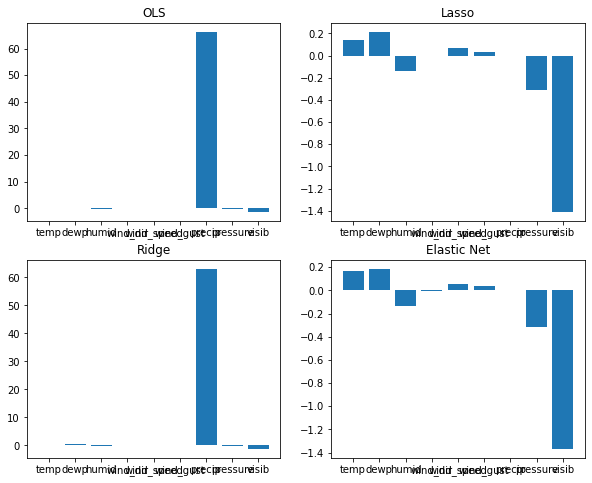

In [11]:
# Merge the flights and weather data on the origin, year, month, day, and hour
flightdata = pd.merge(
    flights, weather, on=["origin", "year", "month", "day", "hour"]
)

# Select the relevant columns and drop missing values
flightdata = flightdata[
    [
        "temp",
        "dewp",
        "humid",
        "wind_dir",
        "wind_speed",
        "wind_gust",
        "precip",
        "pressure",
        "visib",
        "dep_delay",
        "arr_delay",
    ]
].dropna()

# Create the predictor and outcome variables
X = flightdata[
    [
        "temp",
        "dewp",
        "humid",
        "wind_dir",
        "wind_speed",
        "wind_gust",
        "precip",
        "pressure",
        "visib",
    ]
]
y = flightdata["dep_delay"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

# Fit the linear regression models
OLS = LinearRegression()
OLS.fit(X_train, y_train)

lasso = LassoCV(alphas=None, cv=10, max_iter=100000)
lasso.fit(X_train, y_train)

ridge = RidgeCV()
ridge.fit(X_train, y_train)

elastic = ElasticNetCV(l1_ratio=0.5, cv=10, max_iter=100000)
elastic.fit(X_train, y_train)

# Plot the coefficients of the fitted models
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# OLS
axs[0, 0].bar(X.columns, OLS.coef_)
axs[0, 0].set_title("OLS")

# Lasso
axs[0, 1].bar(X.columns, lasso.coef_)
axs[0, 1].set_title("Lasso")

# Ridge
axs[1, 0].bar(X.columns, ridge.coef_)
axs[1, 0].set_title("Ridge")

# Elastic Net
axs[1, 1].bar(X.columns, elastic.coef_)
axs[1, 1].set_title("Elastic Net")

plt.show()

In [12]:
# Merge the flights and weather data on the origin, year, month, day, and hour
flightdata = pd.merge(
    flights, weather, on=["origin", "year", "month", "day", "hour"]
)

# Convert the dep_delay column to a binary indicator of whether the flight was delayed
flightdata["dep_delay"] = flightdata["dep_delay"].apply(
    lambda value: 1 if value > 0 else 0
)

# Drop missing values
flightdata = flightdata.dropna()

# Get the names of the months
months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October","November", "December"]

# Create empty lists for the amount of delayed flights, total flights, and percentage of delayed flights
amount_delayed = [0] * 12
amount_total = [0] * 12
amount_percent = [0] * 12

# Iterate over the rows of the data
for index, row in flightdata.iterrows():

    # Increment the amount of delayed flights in the appropriate month
    if row["dep_delay"] == 1:
        amount_delayed[row["month"] - 1] += 1

    # Increment the total amount of flights in the appropriate month
    amount_total[row["month"] - 1] += 1

# Calculate the percentage of delayed flights for each month
amount_percent = [d / t * 100 for d, t in zip(amount_delayed, amount_total)]

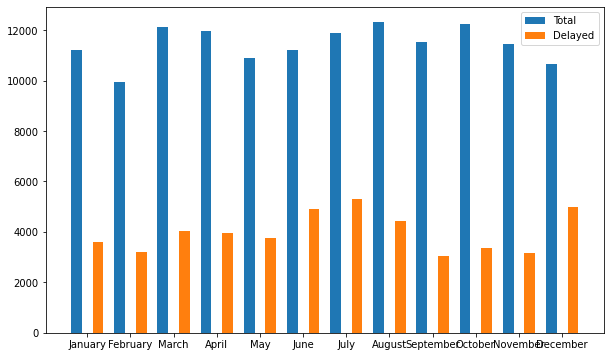

In [15]:
import numpy as np

# Create a figure with the desired size
fig = plt.figure(figsize=(10, 6))

# Add a subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the total and delayed flights as bar charts
ax.bar(
    np.arange(len(months_names)) - 0.25, amount_total,
    width=0.25, label="Total"
)
ax.bar(
    np.arange(len(months_names)) + 0.25, amount_delayed,
    width=0.25, label="Delayed"
)

# Set the x-axis tick labels to the names of the months
ax.set_xticks(np.arange(len(months_names)))
ax.set_xticklabels(months_names)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

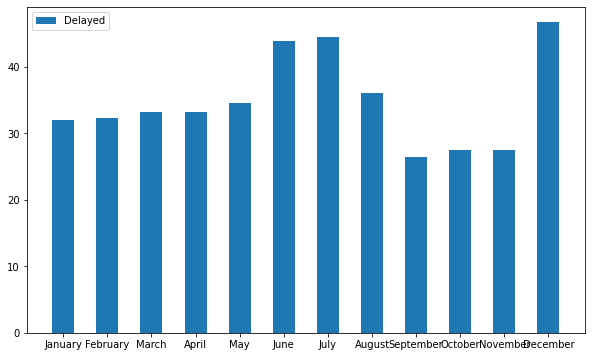

In [16]:
# Create a figure with the desired size
fig = plt.figure(figsize=(10, 6))

# Add a subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the percentage of delayed flights as a bar chart
ax.bar(
    np.arange(len(months_names)), amount_percent, width=0.5,
    label="Delayed"
)

# Set the x-axis tick labels to the names of the months
ax.set_xticks(np.arange(len(months_names)))
ax.set_xticklabels(months_names)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

**(f)** Is the age of the plane associated with delay? Do OLS, Ridge, Lasso, and Elastic Net.

No, and here's why:

In [19]:
# Merge the flights and planes datasets on the tailnum column
flight_data = pd.merge(
    flights.copy(deep=True), planes.copy(deep=True),
    on="tailnum"
)

# Calculate the age of the plane
flight_data["plane_age"] = flight_data["year_x"] - flight_data["year_y"]

# Select the relevant columns
flight_data = flight_data.loc[:, ["plane_age", "dep_delay", "arr_delay"]]

# Drop rows with missing values
flight_data = flight_data.dropna()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    flight_data[["plane_age"]], flight_data["dep_delay"],
    random_state=69
)

# Fit a linear regression model to the data
model = LinearRegression()
model.fit(X_train, y_train)

# Print the model's R-squared score on the training and test sets
print(f"OLS dep and plane age\nTrain data: {model.score(X_train, y_train):.3f}\nTest data: {model.score(X_test, y_test):.3f}")

OLS dep and plane age
Train data: 0.000
Test data: 0.001


In [20]:
# Merge the flights and planes data
flightdata = pd.merge(flights.copy(deep=True), planes.copy(deep=True), on="tailnum")

# Select the columns we need from the merged data
flightdata = flightdata.loc[:,["year_x", "year_y", "dep_delay", "arr_delay"]]

# Calculate the age of each plane by subtracting its year of manufacture from the year of the flight
flightdata["plane_age"] = flightdata["year_x"] - flightdata["year_y"]

# Calculate the arrival delay by subtracting the departure delay from the arrival delay
flightdata["arr_delay"] = flightdata["arr_delay"] - flights["dep_delay"] 

# Drop any rows with missing values
flightdata = flightdata.dropna()

# Select the plane age column as the input features
X = flightdata.loc[:,["plane_age"]]

# Select the arrival delay column as the target variable
y = flightdata.loc[:,["arr_delay"]]

# Split the data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, random_state=69)

# Fit a linear regression model to the training data
ODS = LinearRegression()
ODS.fit(X_train, y_train)

# Print the model's R-squared score on the training and test sets
print(f"OLS arr and plane age\nTrain data: {ODS.score(X_train, y_train):.3f}\nTest data: {ODS.score(X_test, y_test):.3f}")

OLS arr and plane age
Train data: 0.000
Test data: 0.000


In [21]:
# Merge the flights and planes data on the 'tailnum' column
flightdata = pd.merge(flights, planes, on='tailnum')

# Select the columns to include in the model
flightdata = flightdata[['year_x', 'year_y', 'dep_delay', 'arr_delay']]

# Compute the plane's age
flightdata['plane_age'] = flightdata['year_x'] - flightdata['year_y']

# Remove rows with missing values
flightdata = flightdata.dropna()

# Define the features (predictors) and the target (response) variables
X = flightdata[['plane_age']]
y = flightdata['dep_delay']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

In [67]:
# Fit a Ridge regression model to the data
alphas = 10 ** np.linspace(-10, 10, 100)
ridgecv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
ridgecv.fit(X_train, y_train)

# Compute the model's R-squared score on the training and test sets
train_score = ridgecv.score(X_train, y_train)
test_score = ridgecv.score(X_test, y_test)

# Print the R-squared scores
print(f"Ridge\nTrain data: {train_score:.3f} \nTest data: {test_score:.3f}")

# Get the optimal value of the regularization parameter
alpha = model.named_steps["ridgecv"].alpha_
print(f"Optimal regularization parameter: {alpha:.3f}")

Ridge
Train data: 0.034 
Test data: 0.008
Optimal regularization parameter: 8.111


In [29]:
# Create a pipeline that scales the data, fits a LassoCV model, and computes the model's R-squared score
model = make_pipeline(StandardScaler(), LassoCV(cv=10, max_iter=100000))
model.fit(X_train, y_train)

# Compute the model's R-squared score on the training and test sets
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

# Print the R-squared scores
print(f"Lasso\nTrain data: {train_score:.3f} \nTest data: {test_score:.3f}")

# Print the optimal regularization parameter
print(f"Optimal regularization parameter: {model[1].alpha_:.3f}")

Lasso
Train data: 0.000 
Test data: 0.001
Optimal regularization parameter: 0.001


**(g)** Do a principal component analysis of the weather at JFK using the following columns:
   temp, dewp, humid, wind_dir, wind_speed, precip, visib.
   How many principal components should be used to capture the variability in the weather data?

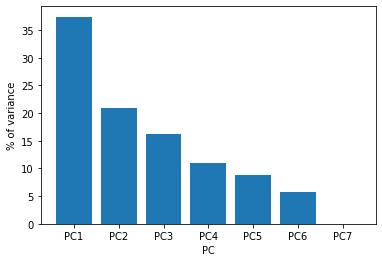

Number of principal components that explain at least 80% of the variance: 0


In [37]:
# Copy the weather data
weather_data = weather.copy(deep=True)

# Filter the data to only include observations from JFK
weather_data = weather_data[weather_data["origin"] == "JFK"]

# Select the columns of interest
weather_data = weather_data[["temp", "dewp", "humid", "wind_dir", "wind_speed", "precip", "visib"]]

# Drop any missing values
weather_data = weather_data.dropna()

# Standardize the data
scaler = StandardScaler()
weather_data_standardized = scaler.fit_transform(weather_data)

# Perform PCA using all columns
pca = PCA()
pca.fit(weather_data_standardized)

# Transform the data using the fitted PCA model
transformed_data = pca.transform(weather_data_standardized)

# Get the explained variance ratio for each principal component
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)

# Create labels for the principal components
labels = ["PC" + str(i) for i in range(1, len(per_var) + 1)]

# Create a bar plot showing the percentage of variance explained by each principal component
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% of variance')
plt.xlabel("PC")
plt.show()

# Print the number of principal components that explain at least 80% of the variance
print(f"Number of principal components that explain at least 80% of the variance: {(per_var >= 80).sum()}")

**(h)** Build regression models (OLS, Ridge, Lasso, and Elastic Net) that associates
   an airports lattitude with weather conditions (temp, dewp, humid, wind_dir, wind_speed,
   precip, visib). Remove all but the three most significant whether conditions and redo
   the analysis.

In [73]:
# Merge the weather and airport data
airportWeather = pd.merge(weather.copy(deep=True), airports.copy(deep=True), left_on='origin', right_on='faa')

# Select the relevant columns from the merged data
airportWeather = airportWeather[["temp", "dewp", "humid", "wind_dir", "wind_speed", "precip", "visib", "lat"]]

# Remove any missing values
airportWeather = airportWeather.dropna()

# Split the data into training and test sets
X = airportWeather[["temp", "dewp", "humid", "wind_dir", "wind_speed", "precip", "visib"]]
y = airportWeather[["lat"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit and evaluate an OLS model
OLS = LinearRegression()
OLS.fit(X_train_scaled, y_train)

# Compute the model's R-squared score on the training and test sets
train_score = OLS.score(X_train_scaled, y_train)
test_score = OLS.score(X_test_scaled, y_test)

# Print the R-squared scores
print(f"OLS\nTrain data: {train_score} \nTest data: {test_score}")

# Fit a Ridge regression model with default regularization parameter
ridgecv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
ridge.fit(X_train_scaled, y_train)

# Compute the model's R-squared score on the training and test sets
train_score = ridge.score(X_train_scaled, y_train)
test_score = ridge.score(X_test_scaled, y_test)

# Print the R-squared scores
print(f"Ridge\nTrain data: {train_score} \nTest data: {test_score}")

# Fit a Lasso regression model with default regularization parameter
lasso = make_pipeline(StandardScaler(), LassoCV(alphas = None, cv = 10, max_iter = 100000))
lasso.fit(X_train_scaled, y_train)

# Compute the model's R-squared score on the training and test sets
train_score = lasso.score(X_train_scaled, y_train)
test_score = lasso.score(X_test_scaled, y_test)

# Print the R-squared scores
print(f"Lasso\nTrain data: {train_score} \nTest data: {test_score}")

# Fit an Elastic Net regression model with default regularization parameter
enet = ElasticNetCV()
enet.fit(X_train_scaled, y_train)

# Compute the model's R-squared score on the training and test sets
train_score = enet.score(X_train_scaled, y_train)
test_score = enet.score(X_test_scaled, y_test)

# Print the R-squared scores
print(f"Elastic Net\nTrain data: {train_score} \nTest data: {test_score}")

OLS
Train data: 0.03449208496831058 
Test data: 0.008142857862870057
Ridge
Train data: 0.034492055927547005 
Test data: 0.0081478231944907


/home/fanimator/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso
Train data: 0.03447529766507962 
Test data: 0.008352541351916765


/home/fanimator/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elastic Net
Train data: 0.034470525010813824 
Test data: 0.008362493623633727


/home/fanimator/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.009e-01, tolerance: 6.194e-03
  model = cd_fast.enet_coordinate_descent(


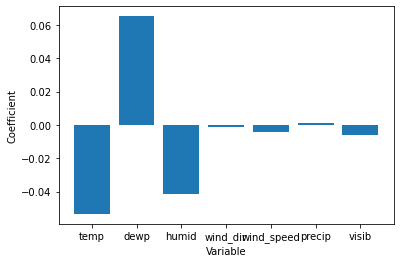

In [60]:
# Get the column names and coefficients from the LassoCV model
col_names = X.columns
coefficients = lasso.coef_

# Create a bar plot showing the coefficients of each variable
fig, ax = plt.subplots()
ax.bar(col_names, coefficients)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Variable')
plt.show()

In [61]:
# Merge the weather and airports dataframes
airportWeather = weather.merge(airports, left_on='origin', right_on='faa')

# Select the relevant columns
airportWeather = airportWeather[["temp", "dewp", "humid", "wind_dir", "wind_speed", "precip", "visib", "lat"]]

# Drop rows with missing values
airportWeather = airportWeather.dropna()

# Split the data into features and target
X = airportWeather[["temp", "dewp", "precip"]]
y = airportWeather[["lat"]]

# Split the data into training and testing sets
X_train, X_test , y_train, y_test = train_test_split(X, y, random_state=69)

In [62]:
# Create the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Evaluate the model on the training and testing data
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

# Print the results
print("Linear Regression\nTrain data: {} \nTest data: {}".format(train_score, test_score))

Linear Regression
Train data: 0.014707683282433437 
Test data: 0.014889853484747695


In [65]:
# Create an array of alpha values
alphas = 10**np.linspace(-10, 10, 100)

# Create a RidgeCV model with the given alpha values
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))

# Fit the model to the training data
model.fit(X_train, y_train)

# Evaluate the model on the training and testing data
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

# Print the results
print("Ridge Regression\nTrain data: {} \nTest data: {}".format(train_score, test_score))

Ridge Regression
Train data: 0.014707430204193295 
Test data: 0.014889508332237122


In [71]:
# Create a LassoCV model
model = make_pipeline(StandardScaler(), LassoCV(cv=10, max_iter=100000))

# Fit the model to the training data
model.fit(X_train, y_train.values.ravel())

# Evaluate the model on the training and testing data
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

# Print the results
print("Lasso Regression\nTrain data: {} \nTest data: {}".format(train_score, test_score))

Lasso Regression
Train data: 0.03447529766507962 
Test data: 0.008352541351916876


**(i)** On a map, plot the airports that have flights to them where the points that represent
   airports are relative in size to the average departure delay. You can see an example in "airports.png".

 **(j)** These questions require no code.
 - Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter or reduce it?

- Why would you want to use:
        > Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?
        > Lasso instead of Ridge Regression?
        > Elastic Net instead of Lasso?

**Answer:**

- If the training error and validation error are almost equal and fairly high when using Ridge Regression, it indicates that the model is **underfitting** the data, which is often caused by high bias. In this situation, it would be appropriate to decrease the regularization hyperparameter, as a lower regularization strength would allow the model to fit the data more closely and potentially reduce the bias.

- **Ridge Regression** is a type of regularized linear regression that uses L2 regularization to **prevent overfitting** by adding a penalty on the coefficients of the model. This can help to improve the generalization performance of the model and prevent overfitting, especially when the number of features is large compared to the number of training examples.

- **Lasso** is a type of regularized linear regression that uses L1 regularization to set some of the coefficients of the model to 0, effectively performing **feature selection** and **eliminating redundant or irrelevant features** from the model. This can make the model more interpretable and **reduce the complexity** of the model, which can improve its performance on unseen data.

- **Elastic Net** is a type of regularized linear regression that combines L1 and L2 regularization, allowing the model to **eliminate irrelevant features** and **reduce the complexity** of the model, while also **avoiding overfitting** by adding a penalty on the coefficients. This can provide the benefits of both Lasso and Ridge Regression, and can be especially useful when there are multiple correlated features in the data.

## 3. Clustering of Handwritten Digits (Franciska)

__You should be able to do this exercise after Lecture 5.__

This exercise will depart from the famous MNIST dataset, and we are exploring several clustering techniques with it.. This is a ".mat" file, in order to load this file in an ipynb you have to use loadmat() function from scipy.io. (replace my path).

In [74]:
mnist = scipy.io.loadmat('3 Clustering of Handwritten Digits/mnist-original')
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

print("Number of datapoints: {}\n".format(mnist_data.shape[0]))
print("Number of features: {}\n".format(mnist_data.shape[1]))
print("List of labels: {}\n".format(np.unique(mnist_label)))

Number of datapoints: 70000

Number of features: 784

List of labels: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]



There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels,
and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s `imshow()` function:

Value of datapoint no. 4:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  46 105 254 254 254 254 255 239  41
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  37
 118 222 254 253 253 253 253 253 253 211  54   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  14 200 253 253 254 253 253 253 253 253
 253 253 116   0   0   0   0   0   0   0   0   0   0   0   0   0  16 160
 236 253 253 253 254 253 

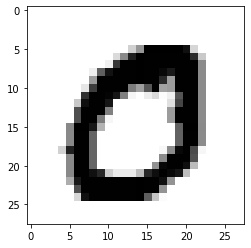

In [76]:
index = 4
print("Value of datapoint no. {}:\n{}\n".format(index, mnist_data[index]))
print("As image:\n")

# Use the reshape method to reshape the data into a 28x28 array
image = mnist_data[index].reshape(28, 28)

# Use imshow to display the image
plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

# It first reshapes the data into a 28x28 array using the `reshape` method,
# then uses the `imshow` function to display the image using
# the grayscale color map `gray_r`.

**(a)** Perform k-means clustering with k=10 on this dataset.

In [78]:
# Scale the data from 0 to 1
scaled_data = mnist_data/255.0

# Create a kmeans model with 10 clusters
kmeans = KMeans(n_clusters=10)

# Fit the model to the data
kmeans.fit(scaled_data)

# KMeans class from the sklearn.cluster module uses it to perform 
# k-means clustering with k=10 on the MNIST dataset.

# It first scales the data by dividing each value by 255,
# then creates a KMeans model with k=10 and fits the model to the data.

KMeans(n_clusters=10)

**(b)** Using visualization techniques analogous to what we have done in the Clustering notebook
   for the faces data, can you determine the 'nature' of the 10 constructed clusters?
   Do the clusters (roughly) coincide with the 10 different actual digits?

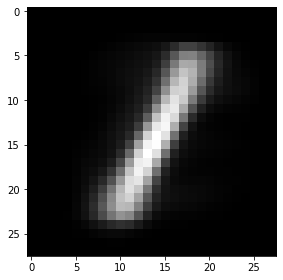

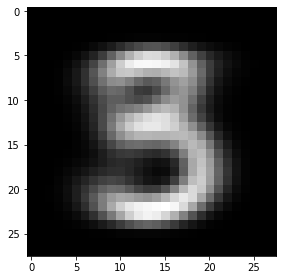

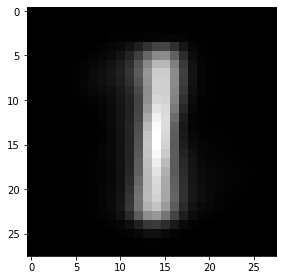

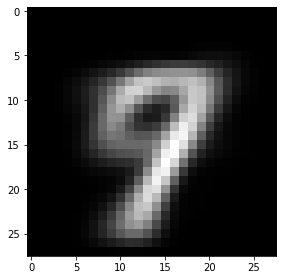

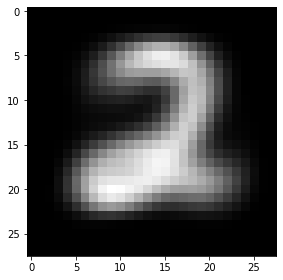

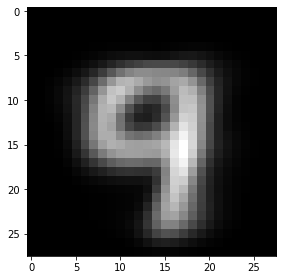

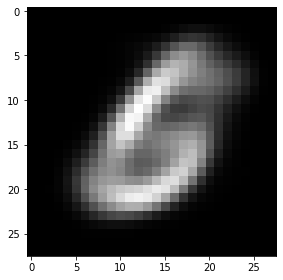

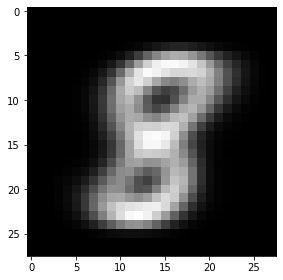

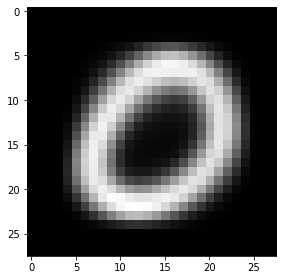

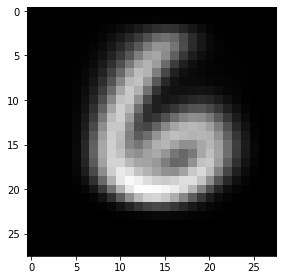

In [79]:
# Loop through the 10 clusters
for i in range(10):
  # Get the cluster center
  center = kmeans.cluster_centers_[i]

  # Reshape the cluster center into a 28x28 array
  image = center.reshape(28, 28)

  # Use imshow to display the image
  plt.imshow(image, cmap=plt.cm.gray)
  plt.tight_layout()
  plt.show()
    
# It loops through each cluster,
# gets the cluster center,
# reshapes it into a 28x28 array, 
# and displays the image using the `imshow` function with 
# the grayscale color map `gray`. 

# This allows us to visualize the "nature" of the 10 constructed 
# clusters and determine whether they roughly coincide with 
# the 10 different actual digits.

**(c)** Perform a supervised clustering evaluation using adjusted rand index.
   Are the results stable, when you perform several random restarts of k-means?

In [82]:
# Resample the data to include 500 samples
small_mnist_data, small_mnist_label = resample(mnist_data, mnist_label, n_samples=500, replace=False)

# Standardize the data
scaler = StandardScaler()
scaler.fit(small_mnist_data)
X_scaled = scaler.transform(small_mnist_data)

# Create a kmeans model with 10 clusters
kmeans = KMeans(n_clusters=10)

# Perform 10 random restarts of kmeans and calculate the ARI for each
for i in range(10):
  # Fit the model to the scaled data and predict the labels
  labels = kmeans.fit_predict(X_scaled)

  # Calculate the adjusted rand index

  # This allows us to determine whether the results of the clustering 
  # are stable when performing multiple random restarts of k-means.
  ari = adjusted_rand_score(labels, small_mnist_label)
  print("ARI of random restarts: {:.2f}".format(ari))

ARI of random restarts: 0.24
ARI of random restarts: 0.27
ARI of random restarts: 0.26
ARI of random restarts: 0.27
ARI of random restarts: 0.26
ARI of random restarts: 0.22
ARI of random restarts: 0.23
ARI of random restarts: 0.28
ARI of random restarts: 0.23
ARI of random restarts: 0.23


In [81]:
# The clusterings generated by the k-means algorithm 
# are only moderately similar to the original labels. => Moderately stable

# This suggests that the k-means algorithm is not performing well 
# on this dataset.

**(d)** Now perform hierarchical clustering on the data.
   (in order to improve visibility in the constructed dendrograms, you can also use a
   much reduced dataset as constructed using sklearn.utils.resample shown below).
   Does the visual analysis of the dendrogram indicate a natural number of clusters?

In [89]:
# Define a function to plot a dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

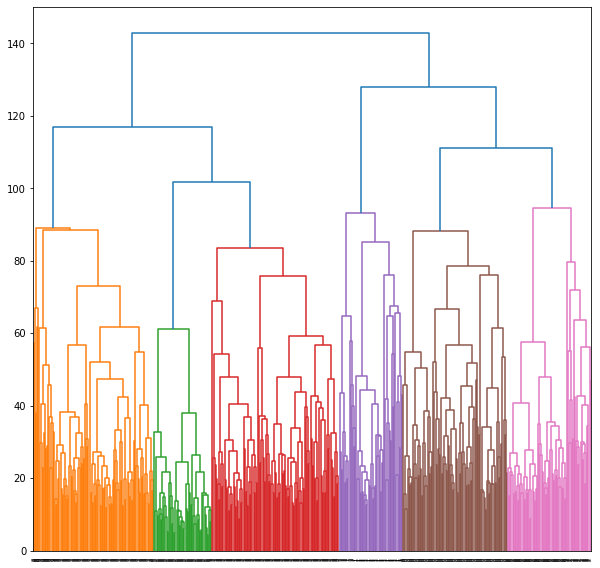

In [90]:
# Resample the data to include 500 samples
small_mnist_data, small_mnist_label = resample(mnist_data, mnist_label, n_samples=500, replace=False, random_state=69)

# Standardize the data
scaler = StandardScaler()
scaler.fit(small_mnist_data)
X_scaled = scaler.transform(small_mnist_data)

# Perform hierarchical clustering with 10 clusters
model = AgglomerativeClustering(n_clusters=10, compute_distances=True)
model.fit(X_scaled)

# Plot the dendrogram
plt.figure(figsize=(10, 10))
plot_dendrogram(model, labels=model.labels_)
plt.show()

**(e)** Using different cluster distance metrics (ward,single,average, etc.),
   what do the clusterings look like that are produced at the level of k=10 clusters?
   See the Clustering notebook for the needed Python code, including the fcluster
   method to retrieve 'plain' clusterings from the hierarchical clustering.

**Ward's method minimizes the sum of squared differences within all clusters, while maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters. Average linkage minimizes the average distance between all pairs of observations in different clusters, and single linkage minimizes the distance between the closest observations in pairs of clusters. These different distance metrics can produce very different clusterings, as they capture different aspects of the underlying structure of the data.**

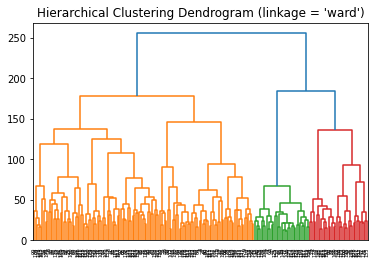

In [95]:
# Load the MNIST data
mnist = load_digits()

# Sample 200 random data points from the MNIST data
small_mnist_data, small_mnist_labels = resample(
    mnist.data,
    mnist.target,
    n_samples=200,
    replace=False
)

# Create an AgglomerativeClustering object with n_clusters=10 and linkage='ward'
agglomerative = AgglomerativeClustering(
    n_clusters=10,
    linkage='ward',
    compute_distances=True
)

# Fit the model to the data and generate a dendrogram
agg = agglomerative.fit(small_mnist_data)
plt.title("Hierarchical Clustering Dendrogram (linkage = 'ward')")
plot_dendrogram(agg)

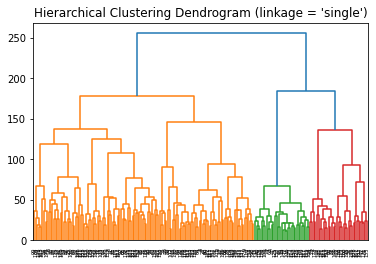

In [96]:
# Repeat the process with linkage='single'
agglomerative = AgglomerativeClustering(
    n_clusters=10,
    linkage='single',
    compute_distances=True
)
agglomerative.fit(small_mnist_data)
plt.title("Hierarchical Clustering Dendrogram (linkage = 'single')")
plot_dendrogram(agg)

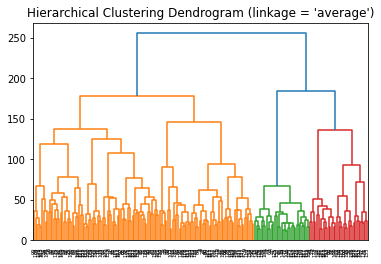

In [97]:
# Repeat the process with linkage='average'
agglomerative = AgglomerativeClustering(
    n_clusters=10,
    linkage='average',
    compute_distances=True
)
agglomerative.fit(small_mnist_data)
plt.title("Hierarchical Clustering Dendrogram (linkage = 'average')")
plot_dendrogram(agg)

**(f)** Do a DBSCAN clustering of the small dataset. Tweak the different parameters.

In [135]:
mnist = scipy.io.loadmat('3 Clustering of Handwritten Digits/mnist-original')
mnist_data = mnist["data"].T
mnist_labels = mnist["label"][0]

In [136]:
# Sample 200 random data points from the MNIST data
small_mnist_data, small_mnist_labels = resample(
    mnist_data,
    mnist_labels,
    n_samples=200,
    replace=False,
    random_state=69
)

data_scaled = small_mnist_data/255.0

In [137]:
for eps in range(1,15):
    # Create an instance of the DBSCAN class with the desired parameters
    dbscan = DBSCAN(eps=eps, min_samples=10)

    # Fit the DBSCAN model to the data and predict the clusters for each data point
    labels = dbscan.fit_predict(data_scaled)

    # Print the results
    print("\n".join(["eps value: " + str(eps), "Clusters present: " + str(np.unique(labels))]))
    print(", ".join(["Cluster sizes:"] + [str(x) for x in np.bincount(labels + 1)]))

eps value: 1
Clusters present: [-1]
Cluster sizes:, 200
eps value: 2
Clusters present: [-1]
Cluster sizes:, 200
eps value: 3
Clusters present: [-1]
Cluster sizes:, 200
eps value: 4
Clusters present: [-1]
Cluster sizes:, 200
eps value: 5
Clusters present: [-1]
Cluster sizes:, 200
eps value: 6
Clusters present: [-1  0]
Cluster sizes:, 189, 11
eps value: 7
Clusters present: [-1  0  1]
Cluster sizes:, 140, 50, 10
eps value: 8
Clusters present: [-1  0]
Cluster sizes:, 58, 142
eps value: 9
Clusters present: [-1  0]
Cluster sizes:, 6, 194
eps value: 10
Clusters present: [-1  0]
Cluster sizes:, 1, 199
eps value: 11
Clusters present: [0]
Cluster sizes:, 0, 200
eps value: 12
Clusters present: [0]
Cluster sizes:, 0, 200
eps value: 13
Clusters present: [0]
Cluster sizes:, 0, 200
eps value: 14
Clusters present: [0]
Cluster sizes:, 0, 200


**The eps parameter controls the maximum distance between two points in the same cluster, so a smaller eps value will result in fewer points being included in each cluster. This can be seen in the output, where the number of clusters and the sizes of the clusters change as the eps value is varied.**

**(g)** Try to compare the different clustering methods on the MNIST dataset in the same way
   the book does on the faces dataset on pp. 195-206.

In [138]:
# Sample 200 random data points from the MNIST data
small_mnist_data, small_mnist_labels = resample(
    mnist_data,
    mnist_labels,
    n_samples=200,
    replace=False,
    random_state=69
)

X_scaled = small_mnist_data/255.0

In [139]:
# Create a kmeans model with 10 clusters
kmeans = KMeans(n_clusters=10)

# Perform 10 random restarts of kmeans and calculate the ARI for each
for i in range(10):
  # Fit the model to the scaled data and predict the labels
  kmeans_labels = kmeans.fit_predict(X_scaled)

In [140]:
# Set a range of eps values to try
eps_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Loop over the eps values
for eps in eps_range:
    # Create the DBSCAN model with the current eps value
    dbscan = DBSCAN(eps=eps, min_samples=2)
    
    # Fit the model to the data and predict the clusters for each data point
    dblabels = dbscan.fit_predict(X_scaled)

    # Print the results
    print("\n".join(["eps value: " + str(eps), "Clusters present: " + str(np.unique(dblabels))]))
    print(", ".join(["Cluster sizes:"] + [str(x) for x in np.bincount(dblabels + 1)]))
    
    # Calculate and print the ARI score for the current value of eps
    print("ARI K-Means vs DBSCAN: {:.2f}".format(adjusted_rand_score(kmeans_labels,dblabels)))

eps value: 1
Clusters present: [-1]
Cluster sizes:, 200
ARI K-Means vs DBSCAN: 0.00
eps value: 2
Clusters present: [-1  0]
Cluster sizes:, 198, 2
ARI K-Means vs DBSCAN: -0.00
eps value: 3
Clusters present: [-1  0  1]
Cluster sizes:, 195, 3, 2
ARI K-Means vs DBSCAN: -0.01
eps value: 4
Clusters present: [-1  0  1  2]
Cluster sizes:, 188, 2, 2, 8
ARI K-Means vs DBSCAN: -0.01
eps value: 5
Clusters present: [-1  0  1  2  3  4  5  6]
Cluster sizes:, 173, 7, 2, 2, 10, 2, 2, 2
ARI K-Means vs DBSCAN: -0.01
eps value: 6
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Cluster sizes:, 134, 22, 8, 3, 2, 3, 2, 2, 10, 2, 2, 2, 3, 3, 2
ARI K-Means vs DBSCAN: 0.00
eps value: 7
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11]
Cluster sizes:, 74, 97, 3, 2, 4, 3, 3, 4, 2, 2, 2, 2, 2
ARI K-Means vs DBSCAN: 0.08
eps value: 8
Clusters present: [-1  0  1]
Cluster sizes:, 24, 174, 2
ARI K-Means vs DBSCAN: 0.02
eps value: 9
Clusters present: [-1  0  1]
Cluster sizes:, 3, 195, 2
ARI K-

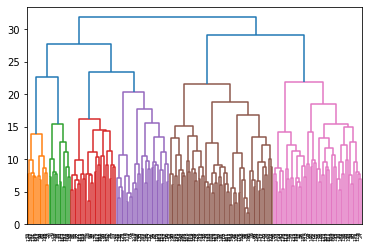

In [149]:
# Create an AgglomerativeClustering object with n_clusters=10
agglomerative = AgglomerativeClustering(
    n_clusters=10,
    compute_distances=True
)

# Fit the model to the data
agg_labels = agglomerative.fit(X_scaled)
plot_dendrogram(agg)

In [162]:
# Define the different label lists
label_lists = [    
    {"K-Means": kmeans_labels},     
    {"Agglomerative": agg_labels.labels_},     
    {"DBSCAN": dblabels}
]

# Loop through the label lists and compute the ARI score with each other list
for i, labels1 in enumerate(label_lists):
    for labels2 in label_lists[i+1:]:
        score = adjusted_rand_score(list(labels1.values())[0], list(labels2.values())[0])
        print("ARI {} vs {}: {:.2f}".format(list(labels1.keys())[0], list(labels2.keys())[0], score))

ARI K-Means vs Agglomerative: 0.38
ARI K-Means vs DBSCAN: 0.00
ARI Agglomerative vs DBSCAN: 0.00


**The scores indicate that the K-Means and Agglomerative clustering algorithms produced clusterings that are 38% similar, while the K-Means and DBSCAN clusterings and the Agglomerative and DBSCAN clusterings are 0% similar. This suggests that the clusterings produced by the different algorithms are quite different from each other.**

In [153]:
# Calculate and print the ARI score for small_mnist_labels vs kmeans_labels
score = adjusted_rand_score(small_mnist_labels, kmeans_labels)
print("ARI small_mnist_labels vs kmeans_labels: {:.2f}".format(score))

ARI small_mnist_labels vs kmeans_labels: 0.25


In [154]:
# Calculate and print the ARI score for small_mnist_labels vs agg_labels
score = adjusted_rand_score(small_mnist_labels, agg_labels.labels_)
print("ARI small_mnist_labels vs agg_labels: {:.2f}".format(score))

ARI small_mnist_labels vs agg_labels: 0.31


In [155]:
# Calculate and print the ARI score for small_mnist_labels vs dblabels
score = adjusted_rand_score(small_mnist_labels, dblabels)
print("ARI small_mnist_labels vs dblabels: {:.2f}".format(score))

ARI small_mnist_labels vs dblabels: 0.00


## 4. The Local Elections

__You should be able to do this exercise after Lecture 6.__

In the local elections of 2021, around 100 candidates stood for election for the city council of Horsens. 83 of them represented a national party, had more than one candidate and provided answers to the <a href="https://www.dr.dk/nyheder/politik/kandidattest">DR Candidate Test</a>, a test designed to help voters find out who they should vote for. In this test, the candidates answered 18 questions, which we will use as features in the following. The politicians belong to 9 parties, which will be our classes.

The numpy files `X_Horsens.npy` and `Y_Horsens.npy` contains the data. `Y_Horsens.npy` contains a letter representing the party to which each candidate belongs. The following parties are represented:

| Party letter | Party name | Party name (English) | Political position | Party color |
| :-: | :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left | Red |
| B | Radikale Venstre | Social Liberal Party | Centre-left | Indigo |
| C | Det Konservative Folkeparti | Conservative People's Party | Right-wing | Green |
| D | Nye Borgerlige | New Right | Far-right | Black |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing | Fuchsia |
| I | Liberal Alliance | Liberal Alliance | Right-wing | Cyan |
| O | Dansk Folkeparti | Danish People's Party | Far-right | Yellow |
| V | Venstre | Danish Liberal Party | Centre-right | Blue |
| Z* | Enhedslisten | Red-Green Alliance | Far-left | Dark red |

*_Note that, although the party letter of Enhedslisten is actually Ø, we will here use Z to avoid any complications with the wonderful Danish letters Æ, Ø and Å. Feel free to change the Z back to an Ø if you find that it does not cause any problems._

Meanwhile, `X_Horsens.npy` contains the answers to the test as numbers between -1.5 and 1.5, such that -1.5 is "Strongly disagree", -0.5 is "Disagree", 0.5 is "Agree" and 1.5 is "Strongly agree". The 18 questions concern, in order, subdivision, schools, windmills, building permits, tall buildings, housing, child care, culture, nursing homes, taxes, sports, refugees, nursing homes (again), public transportation, meat-free days, welfare, privatization, and religious minorities.

Both files can be imported using `numpy.load`.

__(a)__ How well do you (intuitively) expect that we can predict the partisan affiliation of a candidate based on their answers to the test?

__(b)__ Based on the answers from all 83 candidates for the Horsens city council, perform a Principal Component Analysis with 2 principal components. Plot the results in a figure using these 2 components as the axes. Label the points with the party letter and the appropriate color.

__(c)__ Comment on the results. You may consider the following questions for inspiration: Can the political parties be separated? Can the typical distinction of "left-wing" and "right-wing" be discerned? Which of the 18 questions (features) are most important?

The number of candidates (83) is on the (very) low side when we want to do machine learning. Luckily, the neighbouring city of Databorg had no less than 8,300 candidates standing for election, with a political environment similar to that of Horsens. In the following, we will use the data from Databorg. These are stored in the numpy files `X_Databorg.npy` and `Y_Databorg.npy` in same format as the Horsens data.

__(d)__ Once again, perform a Principal Component Analysis and visualize the results. Compare the results to those of the Horsens data.

Confident that we can predict the partisan affiliation of a politician reasonably well based on their answers to the test, we want to build a model that will allow us to distinguish between the 9 political parties. For this purpose, we split the data into a training and a validation set.

__(e)__ Split the data into a training and a validation set, with appropriate fractions.

First, we assume that a Naive Bayes approach is sufficient for our purposes.

__(f)__ Comment on the basic assumption of the Naive Bayes approach. Is this a reasonable assumption for the problem at hand?

__(g)__ Classify the instances of the validation set using a Naive Bayes approach. Comment on the results.

Assume instead that a _k_-nearest neighbour approach is sufficient for our  needs.

__(h)__ Using default settings of the _k_-NN classifier, classify the instances of the validation set. Comment on the performance.

__(i)__ Play around with different values of _k_. Decide on a "good" value of _k_. Comment on the results.

We now try to use a decision tree instead.

__(j)__ What is the _minimum_ depth of an appropriate decision tree? Why?

__(k)__ Build a decision tree with at least the depth from above. Play around with the tree depth. Include a figure that shows some relevant measure of the performance as a function of the tree depth. Comment on any issues of over-fitting. Decide on a tree which you will keep for later use. Can you do better than the _k_-NN classifier?

__(l)__ What are the most important features? Visualize this in an appropriate way. Does it match what you would expect? Compare to the results of the PCA analysis. Do we expect them to be the same? Why/why not?

We know that decision trees suffer from certain problems that may be solved by using decision forests.

__(m)__ Build a decision forest. Play around with the number of trees in the forest. Decide on a forest.

__(n)__ Extract the most important features. Comment and compare with previously obtained results.

Finally, we want to compare the models we have worked with so far (i.e., Naive Bayes, _k_-NN, decision tree and decision forest).

__(o)__ Compare the results of the in terms of confusion matrices, accuracy, precision, recall, and f-score. How well can we predict the partisan affiliation of a candidate based on their answers to a test? How does this compare with your intuition? 

## 5. Sentiment Analysis

__You should be able to do this exercise after Lecture 8.__

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [ ]:
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.

**(b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(e)** Test your sentiment-classifier on the test set.

**(h)** Use the classifier to classify a few sentences you write yourselves. 

## 6. Speech Recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

__(a)__ Explore and prepare the data, including splitting the data in training, validation and testing data, handling outliers, perhaps taking logarithms, etc. Data preparation is - as always - quite important. Document what you do.

__(b)__ Visualize a few examples of yes's, no's, stop's and go's, so that you have a reasonable intuitive understanding of the difference between the words.

__(c)__ Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?

__(d)__ Classify instances of the validation set using your models. Comment on the results in terms of metrics you have learned in the course.

__(e)__ Identify (a few) misclassified words, including what they are misclassified as. Visualize them as before, and compare with your intuitive understanding of how the words look. Do you find the misclassified examples surprising?

## 7. Group Assignment & Presentation



__You should be able to start up on this exercise after Lecture 1.__

*This exercise must be a group effort. That means everyone must participate in the assignment.*

In this assignment you will solve a data science problem end-to-end, pretending to be recently hired data scientists in a company. To help you get started, we've prepared a checklist to guide you through the project. Here are the main steps that you will go through:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore and visualise the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models
7. Present your solution 

In each step we list a set of questions that one should have in mind when undertaking a data science project. The list is not meant to be exhaustive, but does contain a selection of the most important questions to ask. We will be available to provide assistance with each of the steps, and will allocate some part of each lesson towards working on the projects.

Your group must submit a _**single**_ Jupyter notebook, structured in terms of the first 6 sections listed above (the seventh will be a video uploaded to some streaming platform, e.g. YouTube, Vimeo, etc.).

### 1. Analysis: Frame the problem and look at the big picture
1. Find a problem/task that everyone in the group finds interesting
2. Define the objective in business terms
3. How should you frame the problem (supervised/unsupervised etc.)?
4. How should performance be measured?

### 2. Get the data
1. Find and document where you can get the data from
2. Get the data
3. Check the size and type of data (time series, geographical etc)

### 3. Explore the data
1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 4. Prepare the data
Notes:
* Work on copies of the data (keep the original dataset intact).
* Write functions for all data transformations you apply, for three reasons:
    * So you can easily prepare the data the next time you run your code
    * So you can apply these transformations in future projects
    * To clean and prepare the test set
    
    
1. Data cleaning:
    * Fix or remove outliers (or keep them)
    * Fill in missing values (e.g. with zero, mean, median, regression ...) or drop their rows (or columns)
2. Feature selection (optional):
    * Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    * Discretize continuous features
    * Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

### 5. Short-list promising models
We expect you to do some additional research and train at **least one model per team member**.

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables for each algorithm
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

### 7. Present your solution
1. Document what you have done
2. Create a nice 15 minute video presentation with slides
    * Make sure you highlight the big picture first
3. Explain why your solution achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    * Describe what worked and what did not
    * List your assumptions and you model's limitations
5. Ensure your key findings are communicated through nice visualisations or easy-to-remember statements (e.g. "the median income is the number-one predictor of housing prices")
6. Upload the presentation to some online platform, e.g. YouTube or Vimeo, and supply a link to the video in the notebook.

## References

Géron, A. 2017, *Hands-On Machine Learning with Scikit-Learn and Tensorflow*, Appendix B, O'Reilly Media, Inc., Sebastopol.